In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="//fonts.googleapis.com/css?family=Quicksand:300" />
<link rel="stylesheet" type="text/css" href="custom.css">

# Hello Recursive Keras 

Lets take the same weather data as before and let's see if we can predict it better with the help of **DeepLearning[tm]**. This time we'll not do a naive feed forward network but we'll use architectures that are more suited for timeseries.

## Data Setup 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
%matplotlib inline
import patsy as ps 

df_weather = pd.read_csv('data/clean_weather.csv')
df_weather = df_weather.iloc[:365*20]

def assign_season(dataf):
    return (dataf
            .assign(winter = lambda d: d['month'].isin([1,2,3]))
            .assign(spring = lambda d: d['month'].isin([4,5,6]))
            .assign(summer = lambda d: d['month'].isin([7,8,9]))
            .assign(fall = lambda d: d['month'].isin([10,11,12]))
            .assign(truth = lambda d: np.round((d['month']+1)/3) % 4))

def add_lag_variables(dataf, n=1):
    output = dataf.copy()
    for i in range(n):
        output[f'lag{i+1}'] = dataf['max_temp'].shift(i+1)
    return output.dropna()

Let's check what the parsed dataframe looks like.

In [2]:
df_weather = df_weather.pipe(assign_season).pipe(add_lag_variables, n=2)
df_weather.head().T

,2,3,4,5,6
date,1951-01-03,1951-01-04,1951-01-05,1951-01-06,1951-01-07
min_temp,-7,-15,15,63,53
max_temp,17,25,95,95,101
rain,0,0,0,0,0
sunshine_duration,0,0,0,0,0
solar_energy,0,0,0,0,0
day_of_week,Wednesday,Thursday,Friday,Saturday,Sunday
week_of_year,1,1,1,1,1
month,1,1,1,1,1
year,1951,1951,1951,1951,1951


Let's once again define a train and test set. 

In [3]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

cols = df_weather.columns[['lag' in c for c in df_weather.columns]]
y, X = df_weather['max_temp'].values, df_weather[cols].values

In [4]:
df_weather.shape, X.shape, y.shape

((7298, 17), (7298, 2), (7298,))

In [5]:
for train_idx, test_idx in TimeSeriesSplit(n_splits=2).split(X, y):
    print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

print('before reshape:', X_train.shape, X_test.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
print('after resape:', X_train.shape, X_test.shape)

TRAIN: [   0    1    2 ... 2431 2432 2433] TEST: [2434 2435 2436 ... 4863 4864 4865]
TRAIN: [   0    1    2 ... 4863 4864 4865] TEST: [4866 4867 4868 ... 7295 7296 7297]
before reshape: (4866, 2) (2432, 2)
after resape: (4866, 2) (2432, 2)


We've now got a train and test set. 

## The keras part 

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

Using TensorFlow backend.


Before moving on to the layering, we should first consider that sequential layers work differently. 

Recurrent layers in keras can be run in two different modes: 

1. It can return the full sequences of successive outputs for each timestep `(batch_size, timesteps, input_features)`. 
2. Alternatively, it can only output the last output for each input sequence `(batch_size, output_features)`.

Let's demonstrate this effect. 

In [7]:
X_train.shape

(4866, 2)

In [8]:
# return sequences = False 
model = Sequential()
model.add(SimpleRNN(25, input_shape=(1, X_train.shape[1]), return_sequences = True))
model.add(SimpleRNN(10, return_sequences = True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 25)             700       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 1, 10)             360       
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


In [9]:
# return sequences = True 
model = Sequential()
model.add(SimpleRNN(25, input_shape=(1, X_train.shape[1]), return_sequences = True))
model.add(SimpleRNN(10, return_sequences = False))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 1, 25)             700       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                360       
Total params: 1,060
Trainable params: 1,060
Non-trainable params: 0
_________________________________________________________________


Note the minor difference in the summary! The output shape now reads `(None, 10)` instead of `(None, 1, 10)`. 

Let's now do everything properly for an RNN!

In [10]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4866, 1, 2), (2432, 1, 2), (4866,), (2432,))

In [12]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    verbose=2, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 50)                2650      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,171
Trainable params: 3,171
Non-trainable params: 0
_________________________________________________________________
Train on 4866 samples, validate on 2432 samples
Epoch 1/50
 - 0s - loss: 132.6096 - val_loss: 133.1182
Epoch 2/50
 - 0s - loss: 122.9640 - val_loss: 122.1943
Epoch 3/50
 - 0s - loss: 111.2699 - val_loss: 109.2246
Epoch 4/50
 - 0s - loss: 98.2089 - val_loss: 95.3897
Epoch 5/50
 - 0s - loss: 85.2633 - val_loss: 82.4302
Epoch 6/50
 - 0s - loss: 73.8979 - val_loss: 71.9996
Epoch 7/50
 - 0s - loss: 65.0395

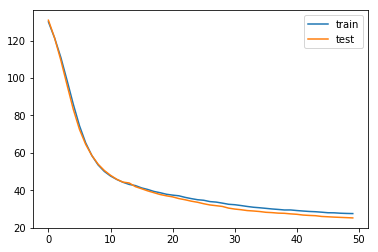

In [13]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

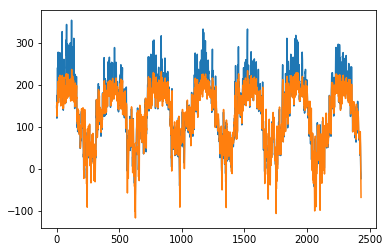

In [13]:
plt.plot(y_test.ravel())
plt.plot(model.predict(X_test).ravel())

With this in mind, let's now consider doing alternative things with recurrent neural networks.

# Predicting Season in Weather Data

With the small RNN introduction out of the way, let us do something more relevant. Let's try and learn the season of the year from the temperature. This time we'll try and do it with a neural network that is more recursive. 

In [14]:
df_weather = df_weather.pipe(assign_season)

y = df_weather[['winter', 'spring', 'summer', 'fall']].values.astype('int32')
X = df_weather['max_temp'].values

In [15]:
for train_idx, test_idx in TimeSeriesSplit(n_splits=2).split(X, y):
    print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

print('before reshape:', X_train.shape, X_test.shape)
X_train = X_train.reshape((X_train.shape[0],1))
X_test = X_test.reshape((X_test.shape[0],1))
print('after resape:', X_train.shape, X_test.shape)

TRAIN: [   0    1    2 ... 2431 2432 2433] TEST: [2434 2435 2436 ... 4863 4864 4865]
TRAIN: [   0    1    2 ... 4863 4864 4865] TEST: [4866 4867 4868 ... 7295 7296 7297]
before reshape: (4866,) (2432,)
after resape: (4866, 1) (2432, 1)


In [16]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4866, 1, 1), (2432, 1, 1), (4866, 4), (2432, 4))

Let's now specify the RNN model. To make things work, let's first change the loss function into something that is relevant for neural networks that need to classify. I've chosen binary crossentropy.

$$ −(y \log(p)+(1−y)\log(1−p)) $$ 

Feel free to read the reminder of why this makes sense [here](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).

## Run the Model

In [18]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model.add(SimpleRNN(50))
model.add(Dense(10))
model.add(Dense(4))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=128, 
                    validation_data=(X_test, y_test), 
                    verbose=2, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 1, 50)             2600      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 44        
Total params: 8,204
Trainable params: 8,204
Non-trainable params: 0
_________________________________________________________________
Train on 4866 samples, validate on 2432 samples
Epoch 1/100
 - 1s - loss: 5.0854 - val_loss: 4.5038
Epoch 2/100
 - 0s - loss: 4.3226 - val_loss: 4.4722
Epoch 3/100
 - 0s - loss: 4.2975 - val_loss: 4.4582
Epoch 4/100
 - 0s - loss: 4.2476 - val_loss: 3.9767
Epoch 5/100
 - 0

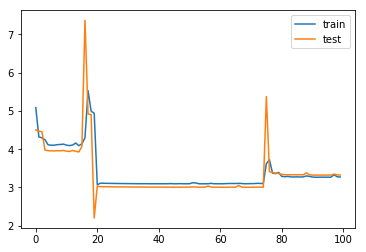

In [19]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

The loss is all over the place! Why?! 

## Exercise 

Fix this model! Remake the model such that it does converge to something meaningful!

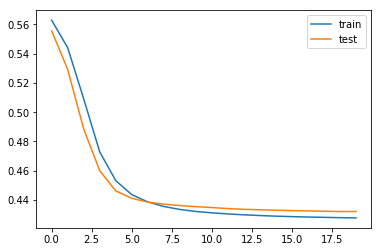

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

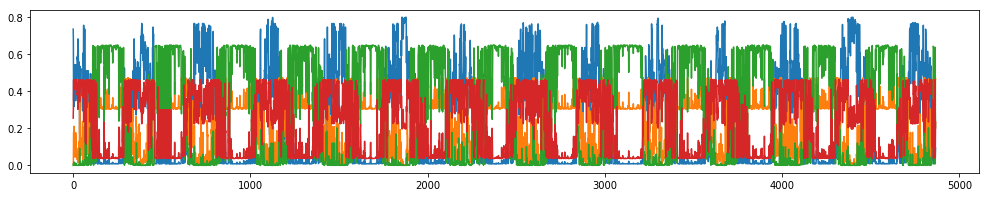

In [23]:
preds = model.predict(X_train)
plt.figure(figsize=(17, 3))
for i in range(y_train.shape[1]):
    plt.plot(preds[:, i])

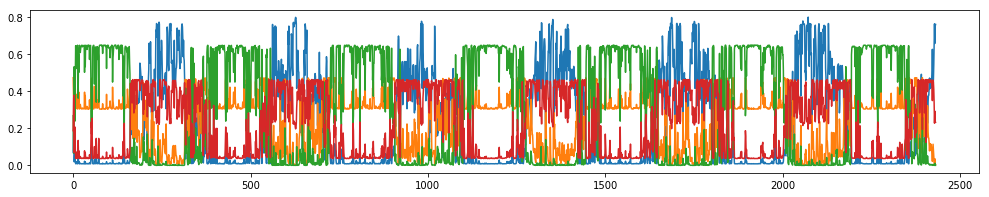

In [24]:
preds = model.predict(X_test)
plt.figure(figsize=(17, 3))
for i in range(y_train.shape[1]):
    plt.plot(preds[:, i])

## Observations 

- Just like with the HMM, we see that being able to know what happened before allows you to infer more. 
- Unlike the HMM, we have no control over the state. The HMM needs us humans to put interpretability onto the state where the RNN needs to figure everything out by itself.
- We haven't done any hyperparameter tuning.